# Naive implementation of statevector simulation

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [25]:
# Gate Definitions
X = np.array([[0, 1], [1, 0]])
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
I = np.eye(2)
CNOT = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0]])

In [26]:
import pennylane as qml
#import pennylane.numpy as np

#### Quantum Circuit simulation using Pennylane

In [27]:
def apply_quantum(qubits):
    dev = qml.device("default.qubit", wires=qubits)

    @qml.qnode(dev)
    def circuit(qubits):
        for wire in range(qubits-1):
            qml.QubitUnitary(X, wires=wire)
            qml.QubitUnitary(H, wires=wire)
            qml.QubitUnitary(CNOT, wires=[wire,wire+1])
        qml.QubitUnitary(X, wires=qubits-1)
        qml.QubitUnitary(H, wires=qubits-1)
        return qml.state()
    
    state = circuit(qubits)
    return state

In [28]:
# Run Circuit with Matrix Multiplication
state1 = apply_quantum(4)
state1

tensor([ 0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
        -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,  0.25+0.j,  0.25+0.j,
        -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j], requires_grad=True)

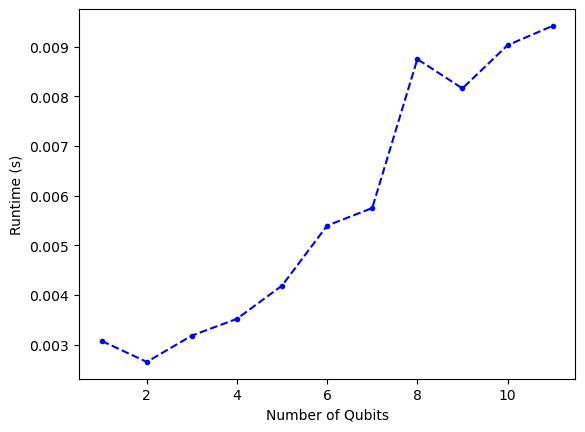

In [29]:
# Runtime Plot
qubits = range(1, 12)
times = []
states = []
for n in qubits:
    start = time.time()
    states.append(apply_quantum(n))
    times.append(time.time() - start)

plt.plot(qubits, times,marker = ".",ls = "--",c="b")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.show()

### Using only matrix multiplication

In [30]:
def direct_sum(a, b):
    m1, n1 = a.shape
    m2, n2 = b.shape
    c = np.zeros((m1 + m2, n1 + n2))
    
    c[:m1, :n1] = a   
    c[m1:, n1:] = b
    return c

In [31]:
# so we already have our operators, now we will calculate time required for computation.

def init_state(qubits):
    state = [1,0]
    for _ in range(qubits-1):
        state = np.kron(state,[1,0])
    return state

In [32]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.quantum_info import Operator

def cnot_op(qubits):
    c = QuantumCircuit(qubits)
    for i in range(qubits-1):
        c.cx(i+1,i)  
    #gate = c.to_gate()
    #matrix = c.to_matrix()
    matrix = Operator.from_circuit(c)
    return matrix.data

In [33]:
print(cnot_op(2))

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]


In [34]:
def apply_numpy(qubits):
    initial = init_state(qubits)
    xop= 1
    hop= 1
    cnotop = cnot_op(qubits)
    for _ in range(qubits):
        xop = np.kron(xop,X)
        hop = np.kron(hop,H)
    
    state_vec = np.dot(xop,initial)
    state_vec = np.dot(hop,state_vec)
    state_vec = np.dot(cnotop,state_vec)
    
    return state_vec

In [35]:
# Run Circuit with Matrix Multiplication
state2 = apply_numpy(4)
state2

array([ 0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j,
       -0.25+0.j,  0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
       -0.25+0.j,  0.25+0.j, -0.25+0.j,  0.25+0.j])

In [36]:
# Runtime Plot
qubits = range(1, 12)
times = []
states = []
for n in qubits:
    start = time.time()
    states.append(apply_numpy(n))
    times.append(time.time() - start)

## Tensor method

In this case instead of using the numpy method we use the tensor method where ibstead of using a 1D vector we use tensor shapes. Therefore instead of representing $|00\rangle$ as `[1,0,0,0]`we instead represent it as `[[1,0],[1,0]]`.

In [45]:
num_qubits = 4
state_tensor = np.reshape([1]+[0]*15, (2,) * num_qubits)
state_tensor

array([[[[1, 0],
         [0, 0]],

        [[0, 0],
         [0, 0]]],


       [[[0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0]]]])

In [46]:
def tensor_apply(state, gate, target, n):
    axes = [target] + list(range(target)) + list(range(target + 1, n))
    gate_expanded = np.tensordot(gate, state, axes=(1, target))
    return np.reshape(gate_expanded, state.shape)

In [58]:
# def twoqubitapply(state, two_qubit_gate, control, target, n):
#     state = np.tensordot(two_qubit_gate, state, axes=([1, 2], [control, target]))

In [59]:
def run_tensor_circuit(n):
    state = np.zeros((2,) * n)
    state[(0,) * n] = 1
    state = tensor_apply(state, X, 0, n)
    state = tensor_apply(state, H, 0, n)
    # state = twoqubitapply(state, CNOT, 0, 1, n)
    return state

In [60]:
qubits_tensor = range(1, 25)
times_tensor = []
states_tensor = []
for n in qubits_tensor:
    start = time.time()
    states_tensor.append(run_tensor_circuit(n))    
    times_tensor.append(time.time() - start)

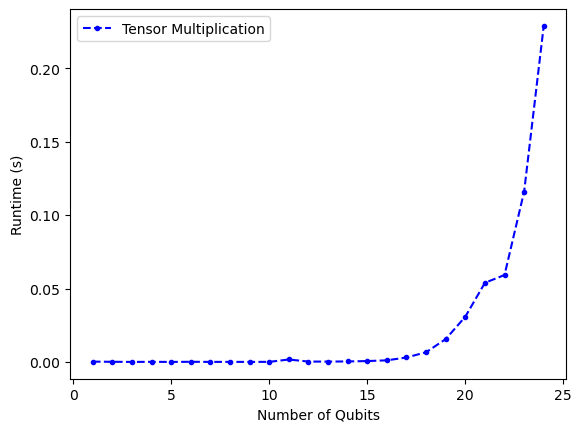

In [61]:
plt.plot(qubits_tensor, times_tensor, label="Tensor Multiplication",marker = ".",ls = "--",c="b")
#plt.plot(qubits, times, label="Matrix Multiplication",marker = ".",ls = "--",c="black")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

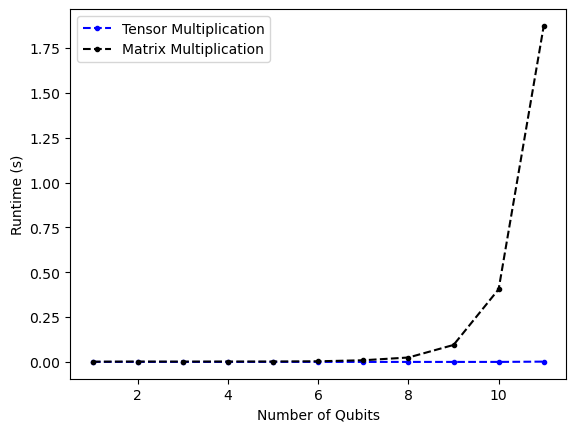

In [62]:
plt.plot(qubits, times_tensor[:11], label="Tensor Multiplication",marker = ".",ls = "--",c="b")
plt.plot(qubits, times, label="Matrix Multiplication",marker = ".",ls = "--",c="black")
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (s)')
plt.legend()
plt.show()

## Bonus

1. Sample from the final states of the statevector or tensor representation
2. Calculate exact expvals from them in the form of $\langle \psi | Op | \psi \rangle$

#### Question 1

In [63]:
states = [state/ np.linalg.norm(state) for state in states]
states_tensor = [state_tensor/ np.linalg.norm(state_tensor) for state_tensor in states_tensor]

In tensor representation

In [ ]:
number = np.random.randint(100)
def samples(number):
    index = np.random.randint(qubits)
    
    qubits = len(states_tensor[index])
    

In [ ]:
sampled_state = np.random.choice(len(probabilities), p=probabilities)

#### Question 2

In [64]:
def expectation_value(state, operator):
    return np.dot(np.conj(state), np.dot(operator, state))